# View Raw Output Images
This notebook lets you open and visualize the contents of the `outputs` folder as grayscale images.

In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np

# Path to outputs folder
outputs_dir = '../../data/outputs'
data_dir = '../../data/raw'
data_csv_dir = '../../data/csv'

# List all files in outputs folder
output_files = [f for f in os.listdir(outputs_dir) if os.path.isfile(os.path.join(outputs_dir, f))]
print('Available output files:')
for f in output_files:
    print(f)

Available output files:
output_hw_lena_512_512_csv.txt
output_software_lena_512_512_raw


In [2]:
# Function to load and display a raw image
def show_raw_image(dir, filename, width, height):
    path = os.path.join(dir, filename)
    with open(path, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.uint8)
    if data.size != width * height:
        print(f'Error: Expected {width*height} bytes, got {data.size}')
        return
    img = data.reshape((height, width))
    plt.imshow(img, cmap='gray')
    plt.title(filename)
    plt.axis('off')
    plt.show()


In [3]:
def show_txt_image(dir, txt_filename, width, height):
    path = os.path.join(dir, txt_filename)
    try:
        data = np.loadtxt(path, dtype=np.uint8)
        if data.size != width * height:
            print(f'Error: Expected {width*height} pixels, got {data.size}')
            return
        img = data.reshape((height, width))
        plt.imshow(img, cmap='gray')
        plt.title(txt_filename)
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f'Error loading image: {e}')

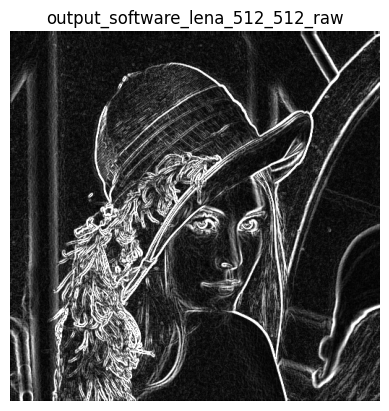

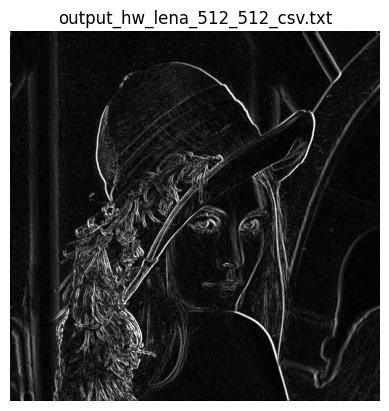

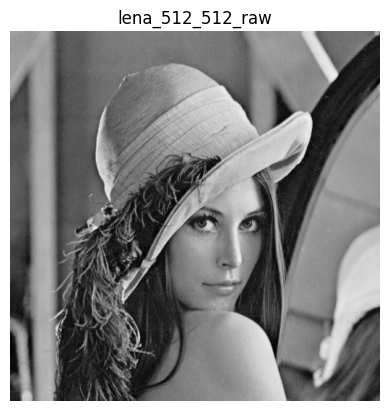

In [4]:
show_raw_image(outputs_dir,'output_software_lena_512_512_raw', 512, 512)
show_txt_image(outputs_dir, 'output_hw_lena_512_512_csv.txt', 510, 510)
show_raw_image(data_dir, 'lena_512_512_raw', 512, 512)

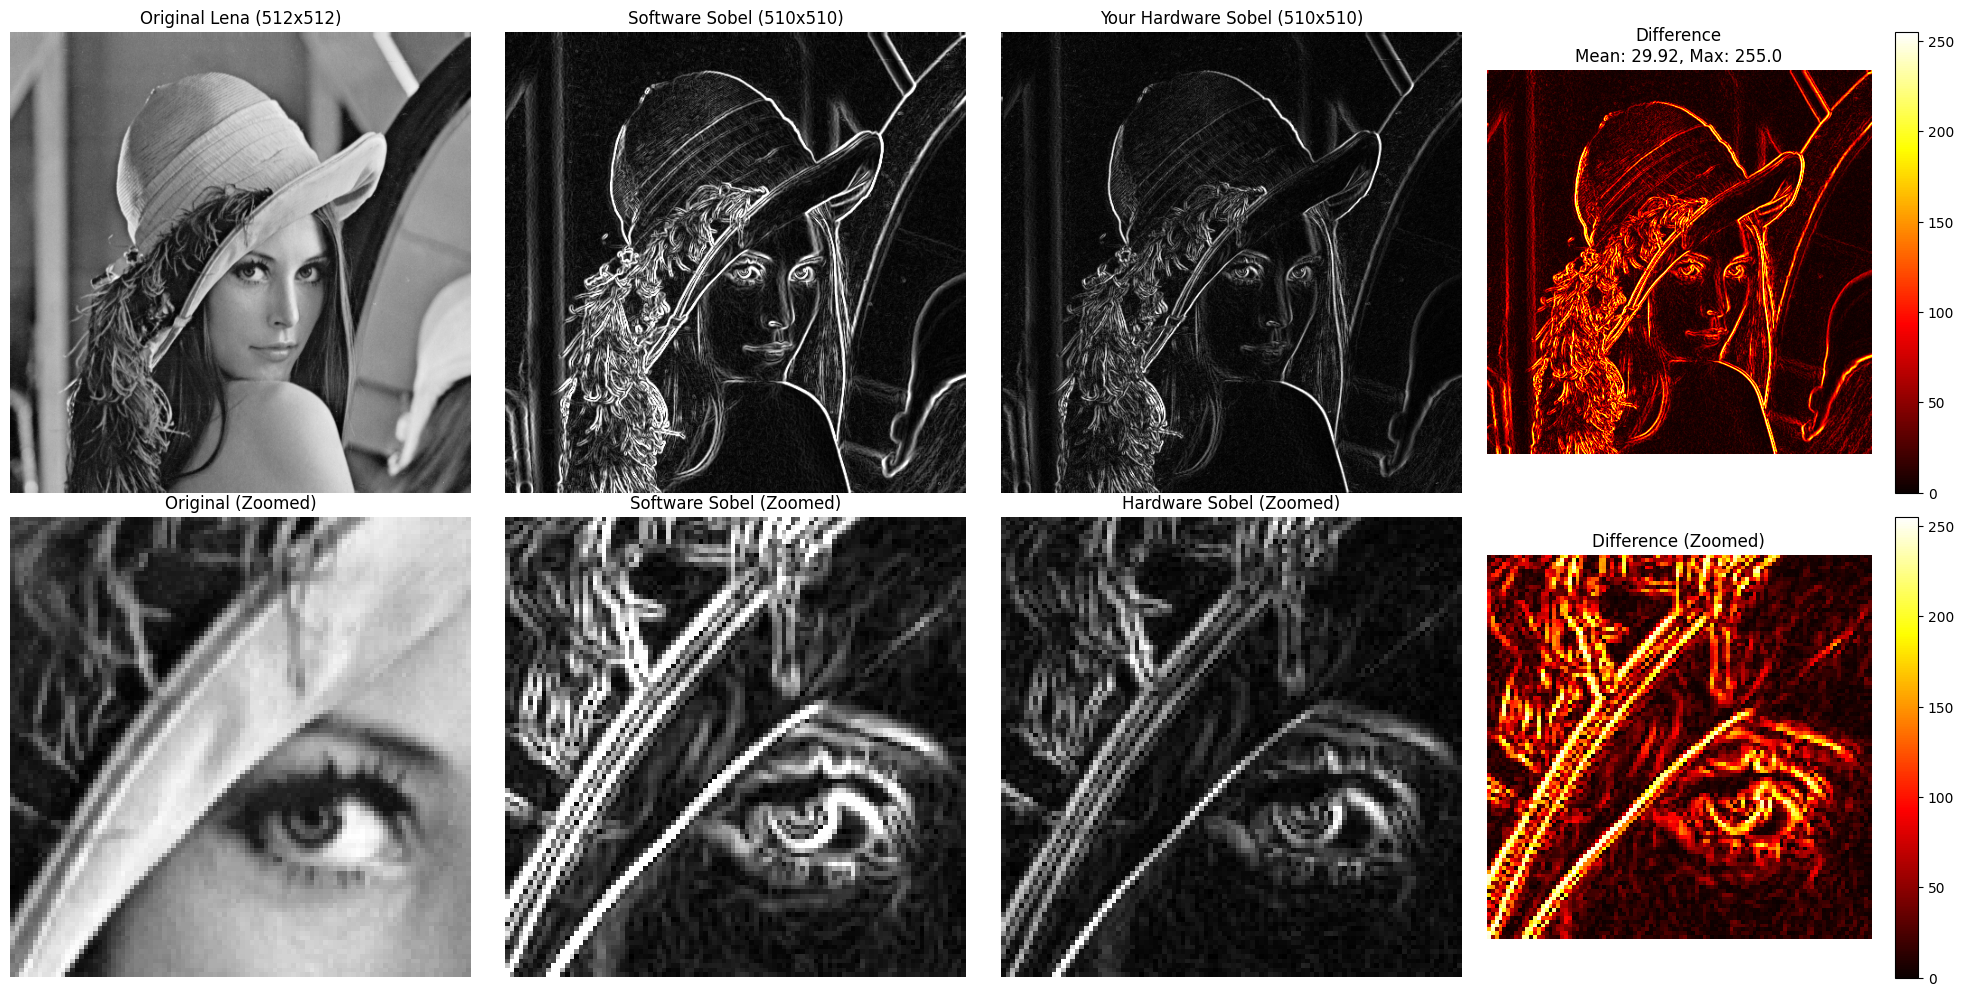

=== COMPARISON STATISTICS ===
Software Sobel range: [0, 255]
Hardware Sobel range: [0, 255]
Difference - Mean: 29.92, Std: 44.74
Pixels with difference > 10: 143061
Pixels with difference > 50: 43628

MODERATE DIFFERENCES: Check normalization/clipping


In [5]:
from scipy import ndimage
import cv2

def compare_with_software_sobel(original_dir, original_file, hw_dir, hw_file):
    # Load original Lena image using your function
    original_path = os.path.join(original_dir, original_file)
    with open(original_path, 'rb') as f:
        original_data = np.frombuffer(f.read(), dtype=np.uint8)
    
    if original_data.size != 512 * 512:
        print(f'Error: Expected {512*512} bytes for original, got {original_data.size}')
        return
    
    original = original_data.reshape((512, 512))
    
    # Software Sobel computation
    sobel_x = cv2.Sobel(original, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(original, cv2.CV_64F, 0, 1, ksize=3)
    software_sobel = cv2.magnitude(sobel_x, sobel_y)
    software_sobel = np.uint8(np.clip(software_sobel, 0, 255))
    
    # Remove borders to match hardware output (510x510)
    software_sobel = software_sobel[1:-1, 1:-1]
    
    # Your hardware output
    hw_path = os.path.join(hw_dir, hw_file)
    hw_data = np.loadtxt(hw_path, dtype=np.uint8)
    hw_sobel = hw_data.reshape((510, 510))
    
    # Calculate difference
    diff = np.abs(software_sobel.astype(float) - hw_sobel.astype(float))
    
    # Create comparison plot
    plt.figure(figsize=(20, 10))
    
    # Original image
    plt.subplot(2, 4, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Original Lena (512x512)')
    plt.axis('off')
    
    # Software Sobel
    plt.subplot(2, 4, 2)
    plt.imshow(software_sobel, cmap='gray')
    plt.title('Software Sobel (510x510)')
    plt.axis('off')
    
    # Your Hardware Sobel
    plt.subplot(2, 4, 3)
    plt.imshow(hw_sobel, cmap='gray')
    plt.title('Your Hardware Sobel (510x510)')
    plt.axis('off')
    
    # Difference
    plt.subplot(2, 4, 4)
    plt.imshow(diff, cmap='hot')
    plt.title(f'Difference\nMean: {np.mean(diff):.2f}, Max: {np.max(diff)}')
    plt.axis('off')
    plt.colorbar()
    
    # Zoomed regions for detailed comparison
    zoom_region = (slice(200, 300), slice(200, 300))  # 100x100 region
    
    plt.subplot(2, 4, 5)
    plt.imshow(original[zoom_region], cmap='gray')
    plt.title('Original (Zoomed)')
    plt.axis('off')
    
    plt.subplot(2, 4, 6)
    plt.imshow(software_sobel[zoom_region], cmap='gray')
    plt.title('Software Sobel (Zoomed)')
    plt.axis('off')
    
    plt.subplot(2, 4, 7)
    plt.imshow(hw_sobel[zoom_region], cmap='gray')
    plt.title('Hardware Sobel (Zoomed)')
    plt.axis('off')
    
    plt.subplot(2, 4, 8)
    plt.imshow(diff[zoom_region], cmap='hot')
    plt.title('Difference (Zoomed)')
    plt.axis('off')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("=== COMPARISON STATISTICS ===")
    print(f"Software Sobel range: [{np.min(software_sobel)}, {np.max(software_sobel)}]")
    print(f"Hardware Sobel range: [{np.min(hw_sobel)}, {np.max(hw_sobel)}]")
    print(f"Difference - Mean: {np.mean(diff):.2f}, Std: {np.std(diff):.2f}")
    print(f"Pixels with difference > 10: {np.sum(diff > 10)}")
    print(f"Pixels with difference > 50: {np.sum(diff > 50)}")
    
    # Check if the issue is systematic
    if np.mean(diff) > 50:
        print("\nLARGE DIFFERENCES DETECTED: Possible kernel/arithmetic issues")
    elif np.mean(diff) > 20:
        print("\nMODERATE DIFFERENCES: Check normalization/clipping")
    else:
        print("\nGOOD MATCH: Minor differences likely due to implementation details")

# Usage
compare_with_software_sobel(
    original_dir=data_dir, 
    original_file='lena_512_512_raw', 
    hw_dir=outputs_dir,
    hw_file='output_hw_lena_512_512_csv.txt'
)

=== IMAGE VALUES ANALYSIS ===
Shape: (512, 512)
Value range: [0, 255]
Mean: 55.27
Std: 63.90
Most common values: [(0, 644), (2, 3252), (4, 6764), (6, 8773), (8, 10745), (10, 11285), (12, 12137), (14, 11685), (16, 11690), (18, 10654)]


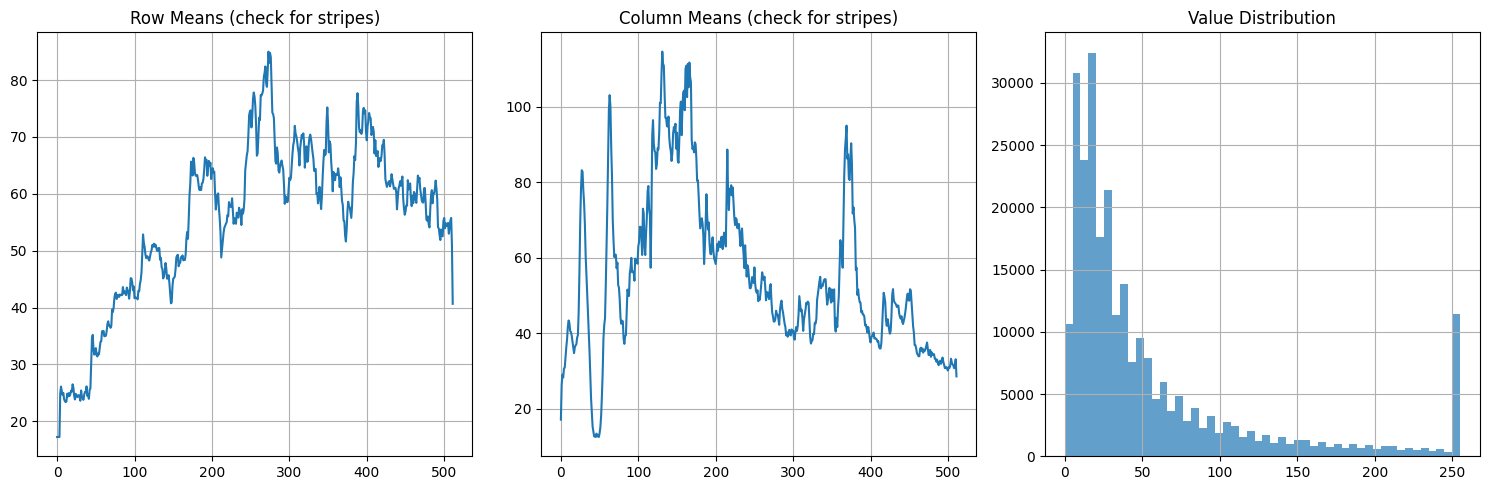

In [6]:
def analyze_image_values(dir_path, file_name, width, height, is_raw=False):
    path = os.path.join(dir_path, file_name)
    if is_raw:
        with open(path, 'rb') as f:
            data = np.frombuffer(f.read(), dtype=np.uint8)
    else:
        data = np.loadtxt(path, dtype=np.uint8)
    img = data.reshape((height, width))
    
    print("=== IMAGE VALUES ANALYSIS ===")
    print(f"Shape: {img.shape}")
    print(f"Value range: [{np.min(img)}, {np.max(img)}]")
    print(f"Mean: {np.mean(img):.2f}")
    print(f"Std: {np.std(img):.2f}")
    
    # Check for unusual patterns
    unique, counts = np.unique(img, return_counts=True)
    print(f"Most common values: {list(zip(unique[:10], counts[:10]))}")
    
    # Check if there are any obvious artifacts
    row_means = np.mean(img, axis=1)
    col_means = np.mean(img, axis=0)
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(row_means)
    plt.title('Row Means (check for stripes)')
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    plt.plot(col_means)
    plt.title('Column Means (check for stripes)')
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    plt.hist(img.flatten(), bins=50, alpha=0.7)
    plt.title('Value Distribution')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

analyze_image_values(outputs_dir, 'output_software_lena_512_512_raw', 512, 512, is_raw=True)

=== IMAGE VALUES ANALYSIS ===
Shape: (510, 510)
Value range: [0, 255]
Mean: 25.48
Std: 34.20
Most common values: [(0, 2957), (2, 12700), (4, 22187), (6, 24333), (8, 24081), (10, 20845), (12, 18117), (14, 14995), (16, 12672), (18, 10561)]


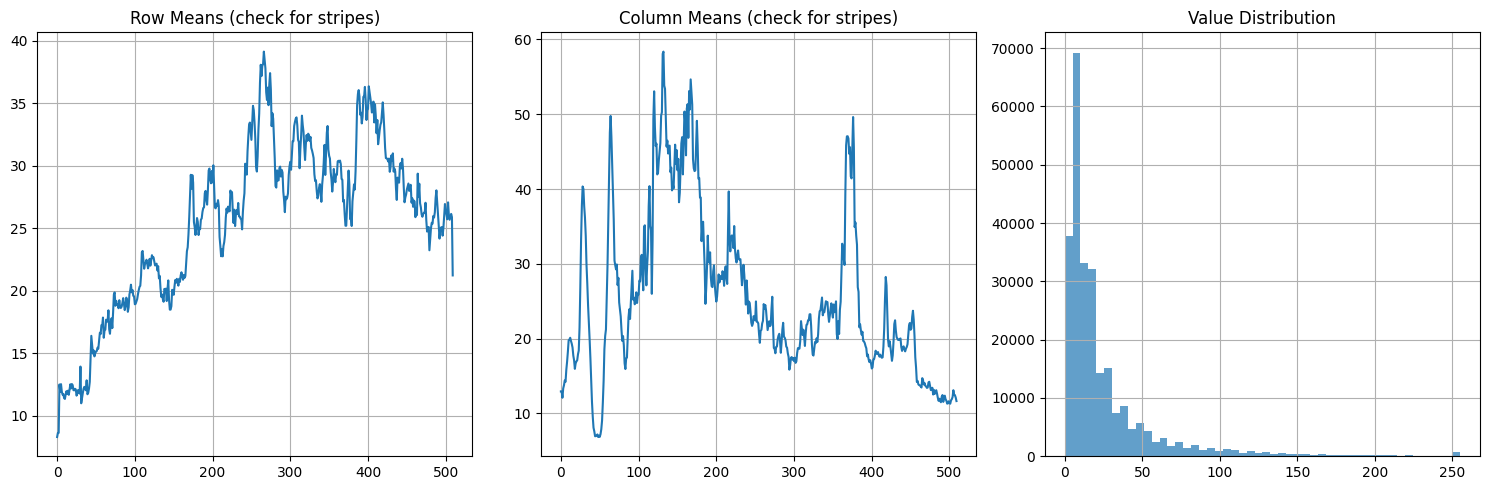

In [7]:
analyze_image_values(outputs_dir, 'output_hw_lena_512_512_csv.txt', 510, 510)

Total pixels: 260100
Value range: [0, 255]
Mean value: 25.48
Unique values: [  0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34
  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70
  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100 102 104 106
 108 110 112 114 116 118 120 122 124 126 128 130 132 134 136 138 140 142
 144 146 148 150 152 154 156 158 160 162 164 166 168 170 172 174 176 178
 180 182 184 186 188 190 192 194 196 198 200 202 204 206 208 210 212 214
 216 218 220 222 224 226 228 230 232 234 236 238 240 242 244 246 248 250
 252 254 255]
First 20 pixels: [ 0  0  0  4  0  8  0  8  4  0  4  0 16  4 12 16  8  4  8  8]


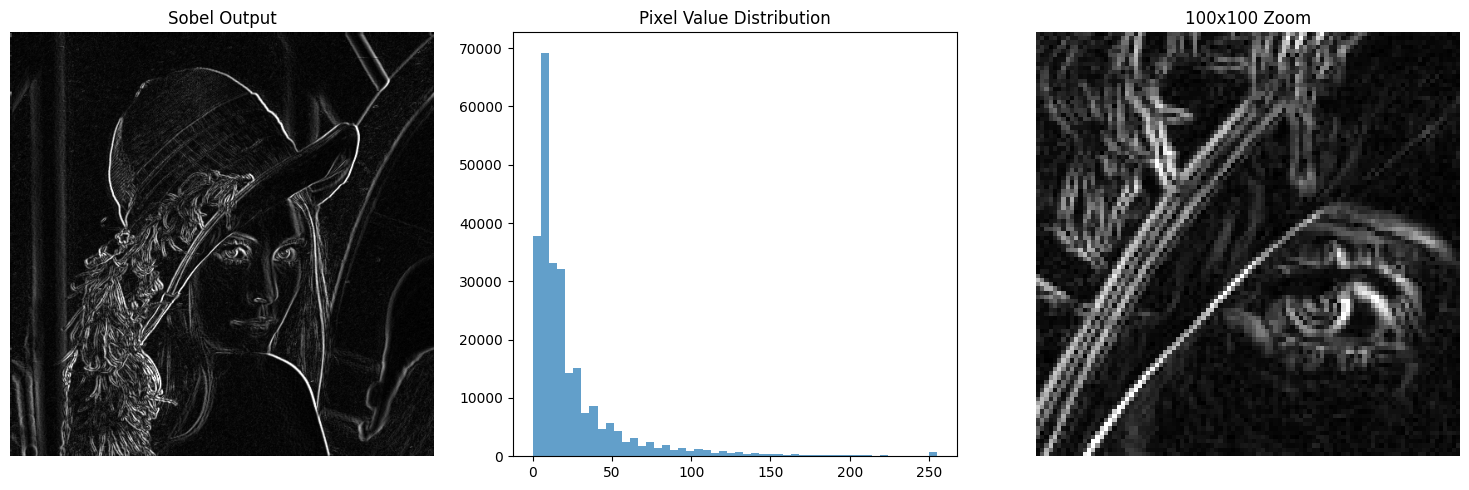

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def debug_sobel_output(dir, txt_filename):
    path = os.path.join(dir, txt_filename)
    data = np.loadtxt(path, dtype=np.uint8)
    
    print(f"Total pixels: {data.size}")
    print(f"Value range: [{np.min(data)}, {np.max(data)}]")
    print(f"Mean value: {np.mean(data):.2f}")
    print(f"Unique values: {np.unique(data)}")
    
    # Check first 20 pixels
    print("First 20 pixels:", data[:20])
    
    # Reshape and display
    img = data.reshape((510, 510))
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Sobel Output')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.hist(data, bins=50, alpha=0.7)
    plt.title('Pixel Value Distribution')
    
    plt.subplot(1, 3, 3)
    # Show a small section to check for patterns
    plt.imshow(img[200:300, 200:300], cmap='gray')
    plt.title('100x100 Zoom')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

debug_sobel_output(outputs_dir, 'output_hw_lena_512_512_csv.txt')


Mean difference: -38.91
Max difference: 84
Min difference: -243


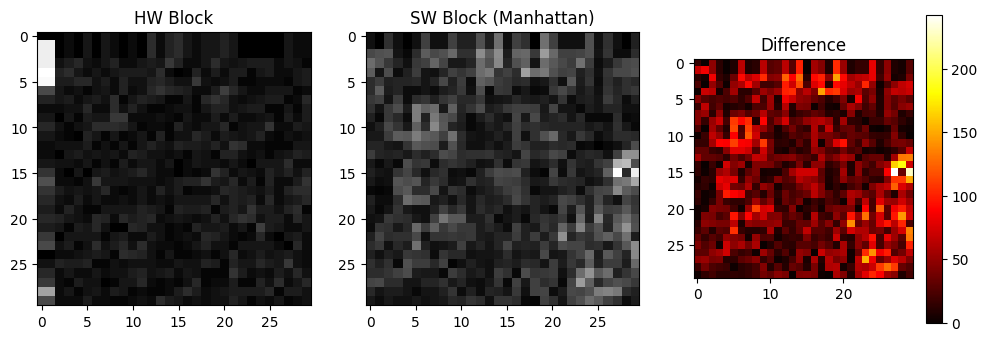


Overall mean diff: 106.13
Pixels with diff > 10: 246000
Pixels with diff > 50: 174073


In [9]:
# Load data
hw_path = os.path.join(outputs_dir, 'output_hw_lena_512_512_csv.txt')
hw_data = np.loadtxt(hw_path, dtype=np.uint8)
hw_img = hw_data.reshape((510, 510))

sw_path = os.path.join(outputs_dir, 'output_software_lena_512_512_raw')
with open(sw_path, 'rb') as f:
    sw_data = np.frombuffer(f.read(), dtype=np.uint8)
sw_img = sw_data.reshape((512, 512))

# Compute software Sobel using Manhattan norm to match HW
sobel_x = cv2.Sobel(sw_img, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(sw_img, cv2.CV_64F, 0, 1, ksize=3)
sw_sobel = np.abs(sobel_x) + np.abs(sobel_y)  # Manhattan norm
sw_sobel = np.uint8(np.clip(sw_sobel, 0, 255))[1:-1, 1:-1]  # Crop to 510x510

# Inspect top-left 30x30 block
block_size = 30
hw_block = hw_img[:block_size, :block_size]
sw_block = sw_sobel[:block_size, :block_size]

# print("Hardware block (top-left 30x30):")
# print(hw_block)
# print("\nSoftware block (top-left 30x30, Manhattan norm):")
# print(sw_block)
# print("\nDifference:")
diff_block = hw_block.astype(int) - sw_block.astype(int)
# print(diff_block)

# Check statistics
print(f"\nMean difference: {diff_block.mean():.2f}")
print(f"Max difference: {diff_block.max()}")
print(f"Min difference: {diff_block.min()}")

# Check if diagonal in this block
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(hw_block, cmap='gray', interpolation='none')
plt.title('HW Block')
plt.subplot(1, 3, 2)
plt.imshow(sw_block, cmap='gray', interpolation='none')
plt.title('SW Block (Manhattan)')
plt.subplot(1, 3, 3)
plt.imshow(np.abs(diff_block), cmap='hot', interpolation='none')
plt.title('Difference')
plt.colorbar()
plt.show()

# Overall comparison
diff = np.abs(sw_sobel - hw_img)
print(f"\nOverall mean diff: {diff.mean():.2f}")
print(f"Pixels with diff > 10: {np.sum(diff > 10)}")
print(f"Pixels with diff > 50: {np.sum(diff > 50)}")